# 2D Code for finite electro-elasticity with u-p formulation.

Problem: Electro-elastic pull-in instability of a 3d VHB  block.

- with basic units:
    - Length: mm
    -  Time:  s
    -   Mass: kg
    - Charge: nC
- and derived units:
    - Pressure: kPa 
    - Force: milliNewtons
    - Electric potential: kV
    
Eric M. Stewart    and    Lallit Anand   
(ericstew@mit.edu)        (anand@mit.edu)   

 October 2023


In [1]:
import numpy as np


from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, FunctionSpace, Expression
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter

import ufl
from ufl import (
    TestFunction,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    tanh,
    as_tensor,
    as_vector,
    ge,
)

from dielectricmodels import DE_2D_PE
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters
import random
import gmsh

In [2]:
problemName = "DE02_2d_Muscle_contractv2"

In [3]:
length = 6
radius = 2

thickness = .2
lc = 0.05
points = [[0, 0], [radius, radius], [radius, length - radius], [0, length]]
points_inside = [
    [0, 0 + thickness],
    [radius - thickness, radius],
    [radius - thickness, length - radius],
    [0, length - thickness],
]
mesh_comm = MPI.COMM_WORLD
model_rank = 0

center1 = [0, radius]
center2 = [0, length - radius]

if mesh_comm.rank == model_rank:
    gmsh.initialize()
    gmsh.model.add("muscle")
    meshpoints = []
    meshpoints_inside = []
    center1 = gmsh.model.geo.add_point(center1[0], center1[1], 0, lc)
    center2 = gmsh.model.geo.add_point(center2[0], center2[1], 0, lc)
    for point in points:
        # print(point)
        meshpoints.append(gmsh.model.geo.add_point(point[0], point[1], 0, lc))

    for point in points_inside:
        # print(point)
        meshpoints_inside.append(gmsh.model.geo.add_point(point[0], point[1], 0, lc))

    l1 = gmsh.model.geo.add_circle_arc(meshpoints[0], center1, meshpoints[1])
    l2 = gmsh.model.geo.add_line(meshpoints[1], meshpoints[2])
    l3 = gmsh.model.geo.add_circle_arc(meshpoints[2], center2, meshpoints[3])
    l4 = gmsh.model.geo.add_line(meshpoints[3], meshpoints_inside[3])
    l5 = gmsh.model.geo.add_circle_arc(
        meshpoints_inside[3], center2, meshpoints_inside[2]
    )
    l6 = gmsh.model.geo.add_line(meshpoints_inside[2], meshpoints_inside[1])
    l7 = gmsh.model.geo.add_circle_arc(
        meshpoints_inside[1], center1, meshpoints_inside[0]
    )
    l8 = gmsh.model.geo.add_line(meshpoints_inside[0], meshpoints[0])

    # l3 =gmsh.model.geo.add_line(meshpoints[2], meshpoints[0])

    loop = gmsh.model.geo.add_curve_loop([l1, l2, l3, l4, l5, l6, l7, l8])

    surface = gmsh.model.geo.addPlaneSurface([1], 1)

    gdim = 2

    gmsh.model.geo.synchronize()

    gmsh.model.addPhysicalGroup(2, [surface], name="My Surface")

    INSIDE_TAG, OUTSIDE_TAG, TOP_TAG, BOTTOM_TAG, GROUND_POINT = 1, 2, 3, 4, 5
    gmsh.model.addPhysicalGroup(1, [l5, l6, l7], INSIDE_TAG, "Inside")
    gmsh.model.addPhysicalGroup(1, [l1, l2, l3], OUTSIDE_TAG, "Outside")
    gmsh.model.addPhysicalGroup(1, [l4], TOP_TAG, "Top")
    gmsh.model.addPhysicalGroup(1, [l8], BOTTOM_TAG, "Bottom")
    gmsh.model.addPhysicalGroup(0, [meshpoints[0]], GROUND_POINT, "Ground")

    gmsh.model.mesh.generate(2)

    gmsh.write("meshes/muscle.msh")
    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Circle)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000518667s, CPU 0.000774s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0146944s, CPU 0.014467s)
Info    : 968 nodes 1940 elements
Info    : Writing 'meshes/muscle.msh'...
Info    : Done writing 'meshes/muscle.msh'


In [4]:
from dolfinx.io.gmshio import read_from_msh

domain, cell_tags, facet_tags = read_from_msh(
    "meshes/muscle.msh", MPI.COMM_WORLD, 0, gdim=2
)


plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Info    : Reading 'meshes/muscle.msh'...
Info    : 19 entities
Info    : 966 nodes
Info    : 1931 elements
Info    : Done reading 'meshes/muscle.msh'


Widget(value="<iframe src='http://localhost:61177/index.html?ui=P_0x28cde1850_0&reconnect=auto' style='width: …

# Simulation Control

In [5]:
t = 0.0  # start time (s)
rampRate = 0.5e-1  # s^{-1}
Ttot = 1.0 / rampRate  # total simulation time (s)
numSteps = 150
dt = Ttot / numSteps  # (fixed) step size
dk = Constant(domain, dt)

In [6]:
DE_prob = DE_2D_PE(domain, length=length)
DE_prob.Kinematics()
DE_prob.WeakForms(dk)
DE_prob.vareps_r.value = -float(DE_prob.vareps_r)

In [7]:
DE_prob.phiTot

131.6600188162661

In [8]:
def muAmp(t):
    return float(DE_prob.phiTot) * t / Ttot

In [9]:
def Ground(x):
        return np.logical_and(np.isclose(x[0],0) , np.isclose(x[1], 0))


Time_cons = Constant(domain, PETSc.ScalarType(muAmp(t)))

U0, submap = DE_prob.ME.sub(0).collapse()
fixed_displacement = fem.Function(U0)
fixed_displacement.interpolate(lambda x :   np.stack((np.zeros(x.shape[1]),np.zeros(x.shape[1]))))


tags = np.unique(np.concatenate((facet_tags.find(TOP_TAG),facet_tags.find(BOTTOM_TAG))))

dofs_1 = fem.locate_dofs_topological(
    DE_prob.ME.sub(0).sub(0), facet_tags.dim,tags
)
dofs_2 = fem.locate_dofs_geometrical(
    (DE_prob.ME.sub(0),U0), Ground
)

dofs_3 = fem.locate_dofs_topological(
    DE_prob.ME.sub(2), facet_tags.dim, facet_tags.find(INSIDE_TAG)
)
dofs_4 = fem.locate_dofs_topological(
    DE_prob.ME.sub(2), facet_tags.dim, facet_tags.find(OUTSIDE_TAG)
)


bcs_1 = dirichletbc(0.0, dofs_1, DE_prob.ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(fixed_displacement, dofs_2, DE_prob.ME.sub(0))  # u2 fix - yBot

bcs_3 = dirichletbc(0.0, dofs_3, DE_prob.ME.sub(2))  # u2 fix - yBot
bcs_4 = dirichletbc(Time_cons, dofs_4, DE_prob.ME.sub(2))  # u3 fix - zBot

#
bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

# Set Output File

In [10]:
import dolfinx

U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)  # Vector function space
V1 = fem.FunctionSpace(domain, DE_prob.P1)  # Scalar function space

u_vis = Function(V2)
u_vis.name = "u"
u_expr = Expression(DE_prob.u, V2.element.interpolation_points())


p_vis = Function(V1)
p_vis.name = "p"
p_expr = Expression(DE_prob.p, V1.element.interpolation_points())

phi_Vis = Function(V1)
phi_Vis.name = "phi"
phi_expr = Expression(DE_prob.phi, V1.element.interpolation_points())


T = DE_prob.Tmat * DE_prob.F.T / DE_prob.J  # Cauchy Stress

T0 = T - (1 / 3) * tr(T) * Identity(3)
Mises = sqrt((3 / 2) * inner(T0, T0))


Mises_vis = Function(V1)
Mises_vis.name = "Mises"
mises_expr = Expression(Mises, V1.element.interpolation_points())

# vtk2 = VTXWriter(domain.comm,"results/"+problemName+"displacement.bp", [u_vis], engine="BP4" )

vtk = VTXWriter(
    domain.comm,
    "results/" + problemName + ".bp",
    [u_vis, p_vis, phi_Vis, Mises_vis],
    engine="BP4",
)

files = [vtk]


def interp_and_save(t, files: list[VTXWriter]):
    u_vis.interpolate(u_expr)
    p_vis.interpolate(p_expr)
    phi_Vis.interpolate(phi_expr)
    Mises_vis.interpolate(mises_expr)

    for file in files:
        file.write(t)


pointForStress = [0, length, 0]
bb_tree = dolfinx.geometry.bb_tree(domain, domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForStress)
colliding_cells = dolfinx.geometry.compute_colliding_cells(
    domain, cell_candidates, pointForStress
)

In [11]:
import os

step = "Swell"
jit_options = {"cffi_extra_compile_args": ["-O3", "-ffast-math"]}

problem = NonlinearProblem(
    DE_prob.Res, DE_prob.w, bcs, DE_prob.a, jit_options=jit_options
)

totSteps = numSteps + 1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])

solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 30
solver.report = True
solver.error_on_nonconvergence = False

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_max_it"] = 30
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

startTime = datetime.now()
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

step = "Actuate"

# if os.path.exists("results/"+problemName+".bp"):
#    os.remove("results/"+problemName+".xdmf")
#    os.remove("results/"+problemName+".h5")

# vtk.write_mesh(domain)
t = 0.0
# log.set_log_level(log.LogLevel.INFO)
interp_and_save(t, files)
ii = 0
bisection_count = 0
totSteps = numSteps + 1

timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])

while round(t + dt, 9) <= Ttot:
    # increment time
    t += float(dt)
    # increment counter
    ii += 1
    Time_cons.value = muAmp(t)

    # Solve the problem

    (iter, converged) = solver.solve(DE_prob.w)

    if converged:
        DE_prob.w.x.scatter_forward()
        DE_prob.w_old.x.array[:] = DE_prob.w.x.array

        timeHist0[ii] = (
            DE_prob.w.sub(0).sub(1).eval(pointForStress, colliding_cells[0])[0]
        )
        timeHist1[ii] = DE_prob.w.sub(2).eval(pointForStress, colliding_cells[0])[
            0
        ]  # time history of voltage phi

        interp_and_save(t, files)

        if ii % 1 == 0:
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")

            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print(f"Simulation Time: {t:.2f} s | dt: {float(dt):.4f}s")
            print()
        # Reset Biseciton Counter
        bisection_count = 0

        #
        # If the newton solver takes 3 or less iterations,
        # increase the time step by a factor of 1.5:
        if iter <= 3:
            dt = 1.5 * dt
            dk.value = dt
        # If the newton solver takes 5 or more iterations,
        # decrease the time step by a factor of 2:
        elif iter >= 10:
            dt = dt / 2
            dk.value = dt
        # otherwise the newton solver took 3-4 iterations,
        # in which case leave the time step alone.

    else:
        print("Error Halfing Time Step")
        bisection_count += 1
        if bisection_count > 5:
            print("Too Many Bisections")
            break

        # first, we back up in time
        # ( to un-do the current time step )
        t = t - float(dk)

        # Then, we cut back on the time step we're attempting.
        # (by a factor of 2)
        dt = dt / 2
        dk.value = dt

        # Finally, we have to reset the degrees of freedom to their
        # "old" values before trying to solve again, otherwise the
        # initial guess for w is retained from the "failed" solve attempt.
        DE_prob.w.x.array[:] = DE_prob.w_old.x.array
        DE_prob.w.x.scatter_forward()


# End Analysis

for file in files:
    file.close()
endTime = datetime.now()
print("------------------------------------")
print("Simulation End")
print("------------------------------------")
print("Total Time: {}".format(endTime - startTime))
print("------------------------------------")

------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 5
Simulation Time: 0.13 s | dt: 0.1333s

Step: Actuate |   Increment: 2 | Iterations: 5
Simulation Time: 0.27 s | dt: 0.1333s

Step: Actuate |   Increment: 3 | Iterations: 5
Simulation Time: 0.40 s | dt: 0.1333s

Step: Actuate |   Increment: 4 | Iterations: 5
Simulation Time: 0.53 s | dt: 0.1333s

Step: Actuate |   Increment: 5 | Iterations: 5
Simulation Time: 0.67 s | dt: 0.1333s

Step: Actuate |   Increment: 6 | Iterations: 5
Simulation Time: 0.80 s | dt: 0.1333s

Step: Actuate |   Increment: 7 | Iterations: 5
Simulation Time: 0.93 s | dt: 0.1333s

Step: Actuate |   Increment: 8 | Iterations: 5
Simulation Time: 1.07 s | dt: 0.1333s

Step: Actuate |   Increment: 9 | Iterations: 5
Simulation Time: 1.20 s | dt: 0.1333s

Step: Actuate |   Increment: 10 | Iterations: 5
Simulation Time: 1.33 s | dt: 0.1333s

Step: Actuate |   Increment: 11 | Iterations: 5


2023-11-09 03:08:55.471 (  13.571s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.


Error Halfing Time Step
Error Halfing Time Step


2023-11-09 03:08:55.751 (  13.850s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.
2023-11-09 03:08:56.020 (  14.119s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.


Error Halfing Time Step


2023-11-09 03:08:56.297 (  14.396s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.


Error Halfing Time Step


2023-11-09 03:08:56.572 (  14.671s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.


Error Halfing Time Step
Too Many Bisections
------------------------------------
Simulation End
------------------------------------
Total Time: 0:00:13.582842
------------------------------------


2023-11-09 03:08:56.841 (  14.940s) [main            ]       NewtonSolver.cpp:273   WARN| Newton solver did not converge.


  normVolts = timeHist1 / (length * np.sqrt(float(DE_prob.Geq_0) / float(DE_prob.vareps)))



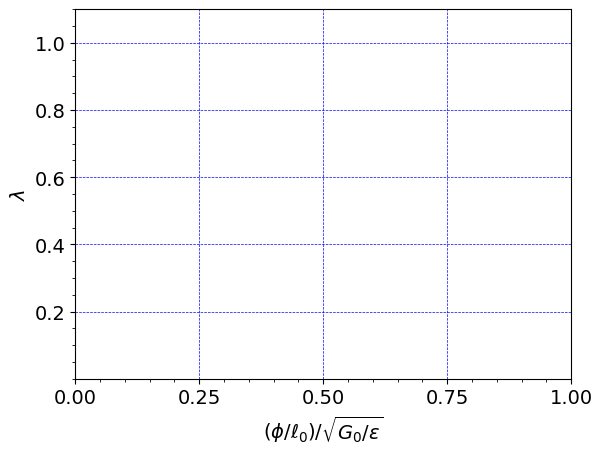

<Figure size 600x400 with 0 Axes>

ERROR:aiohttp.server:Error handling request
Traceback (most recent call last):
  File "/Users/jorgenin/Documents/Python/Research/2.077/.venv/lib/python3.11/site-packages/aiohttp/web_protocol.py", line 433, in _handle_request
    resp = await request_handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jorgenin/Documents/Python/Research/2.077/.venv/lib/python3.11/site-packages/aiohttp/web_app.py", line 504, in _handle
    resp = await handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jorgenin/Documents/Python/Research/2.077/.venv/lib/python3.11/site-packages/wslink/backends/aiohttp/__init__.py", line 210, in handleWsRequest
    await current_ws.prepare(request)
  File "/Users/jorgenin/Documents/Python/Research/2.077/.venv/lib/python3.11/site-packages/aiohttp/web_ws.py", line 138, in prepare
    payload_writer = await super().prepare(request)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jorgenin/Documents/Python/Research/2.077/.v

In [12]:
"""""" """""" """""" """
    VISUALIZATION
""" """""" """""" """"""
import matplotlib.pyplot as plt

# set plot font to size 14
font = {"size": 14}
plt.rc("font", **font)

# Get array of default plot colors
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus stretch in the vertical direction.
#
normVolts = timeHist1 / (length * np.sqrt(float(DE_prob.Geq_0) / float(DE_prob.vareps)))
normVolts = normVolts[0:ii]
#
stretch = timeHist0 / length + 1.0
stretch = stretch[0:ii]
#
plt.plot(normVolts, stretch, c=colors[0], linewidth=1.0, marker=".")
# plt.scatter(normVolts[ii-1], stretch[ii-1], c='k', marker='x', s=100)
# plt.scatter(normVolts[ii-1], stretch[ii-1], c='k',  s=100)
plt.grid(linestyle="--", linewidth=0.5, color="b")
ax = plt.gca()
#
ax.set_ylabel(r"$\lambda$")
ax.set_ylim([0.0, 1.1])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
#
ax.set_xlabel(r"$(\phi/\ell_0)/\sqrt{G_0/\varepsilon} $")
ax.set_xlim([0.2, 1.0])
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
#
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()

fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout()
plt.savefig("results/" + problemName + ".png", dpi=600)